## Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

def load_data(filepath):
    df = pd.read_csv(filepath)
    # Drop ID if exists
    if 'id' in df.columns:
        df = df.drop('id', axis=1)
    
    # Encode Diagnosis: M=1, B=0
    df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
    return df

df = load_data('wdbc_clean.csv')
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

print("Data Loaded. Shape:", df.shape)

Data Loaded. Shape: (569, 31)


## Task 2: Paper Replication
Replicating Tables 2, 4, 6, and 7 from the paper using F-score feature selection and SVM Grid Search.

In [2]:
# F-score Implementation (Eq. 19)
def calculate_f_score(X, y):
    X_pos = X[y == 1]
    X_neg = X[y == 0]
    
    x_bar = X.mean()
    x_pos_bar = X_pos.mean()
    x_neg_bar = X_neg.mean()
    
    numerator = (x_pos_bar - x_bar)**2 + (x_neg_bar - x_bar)**2
    var_pos = X_pos.var(ddof=1)
    var_neg = X_neg.var(ddof=1)
    denominator = var_pos + var_neg
    
    f_scores = numerator / denominator.replace(0, np.nan)
    return f_scores.fillna(0)

# Grid Search for SVM
def optimize_svm(X_train, y_train):
    # Coarser grid for speed as optimized in previous steps
    C_range = [2**i for i in range(-5, 16, 2)]
    gamma_range = [2**i for i in range(-15, 4, 2)]
    
    param_grid = dict(gamma=gamma_range, C=C_range)
    cv = StratifiedKFold(n_splits=5)
    
    grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_, grid.best_params_

# Main Replication Loop
partitions = {
    '50-50': 0.5,
    '70-30': 0.3,
    '80-20': 0.2
}

results_table_4 = {}
results_table_2 = {}
model_5_metrics = {}

for name, test_size in partitions.items():
    print(f"\nProcessing Partition: {name}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    
    # Feature Selection
    f_scores = calculate_f_score(X_train, y_train)
    f_scores_sorted = f_scores.sort_values(ascending=False)
    results_table_2[name] = f_scores_sorted
    ranked_features = f_scores_sorted.index.tolist()
    
    accuracies = []
    
    # Models 1-9
    for k in range(1, 10):
        top_k_feats = ranked_features[:k]
        X_train_sub = X_train_scaled[top_k_feats]
        X_test_sub = X_test_scaled[top_k_feats]
        
        best_svm, best_params = optimize_svm(X_train_sub, y_train)
        y_pred = best_svm.predict(X_test_sub)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc * 100)
        
        print(f"  Model #{k}: Acc = {acc*100:.2f}%")
        
        if k == 5:
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            model_5_metrics[name] = {
                'Sensitivity': tp / (tp + fn) * 100,
                'Specificity': tn / (tn + fp) * 100,
                'PPV': tp / (tp + fp) * 100,
                'NPV': tn / (tn + fn) * 100,
                'Confusion Matrix': (tn, fp, fn, tp)
            }
    results_table_4[name] = accuracies

# Display Results
print("\n=== Table 2: Feature Importance (Top 10) ===")
t2_df = pd.DataFrame()
for name, scores in results_table_2.items():
    t2_df[f'{name} Feature'] = scores.index[:10]
    t2_df[f'{name} F-score'] = scores.values[:10]
display(t2_df)

print("\n=== Table 4: Classification Accuracies (%) ===")
t4_df = pd.DataFrame(results_table_4, index=[f'#{i}' for i in range(1, 10)])
display(t4_df)

print("\n=== Table 6 & 7: Model #5 Performance ===")
for name, metrics in model_5_metrics.items():
    print(f"\nPartition {name}:")
    for k, v in metrics.items():
        print(f"  {k}: {v}")


Processing Partition: 50-50
  Model #1: Acc = 92.28%
  Model #2: Acc = 94.39%
  Model #3: Acc = 94.39%
  Model #4: Acc = 94.74%
  Model #5: Acc = 94.04%
  Model #6: Acc = 95.44%
  Model #7: Acc = 95.79%
  Model #8: Acc = 95.09%
  Model #9: Acc = 96.14%

Processing Partition: 70-30
  Model #1: Acc = 93.57%
  Model #2: Acc = 92.98%
  Model #3: Acc = 94.74%
  Model #4: Acc = 94.74%
  Model #5: Acc = 95.32%
  Model #6: Acc = 94.74%
  Model #7: Acc = 95.91%
  Model #8: Acc = 95.91%
  Model #9: Acc = 95.91%

Processing Partition: 80-20
  Model #1: Acc = 91.23%
  Model #2: Acc = 94.74%
  Model #3: Acc = 95.61%
  Model #4: Acc = 94.74%
  Model #5: Acc = 95.61%
  Model #6: Acc = 95.61%
  Model #7: Acc = 96.49%
  Model #8: Acc = 96.49%
  Model #9: Acc = 96.49%

=== Table 2: Feature Importance (Top 10) ===


,50-50 Feature,50-50 F-score,70-30 Feature,70-30 F-score,80-20 Feature,80-20 F-score
0,concave_points_worst,1.516239,concave_points_worst,1.645608,concave_points_worst,1.709588
1,perimeter_worst,1.484581,perimeter_worst,1.483969,perimeter_worst,1.490785
2,radius_worst,1.452614,radius_worst,1.425419,radius_worst,1.442487
3,concave_points_mean,1.336579,concave_points_mean,1.349528,concave_points_mean,1.414434
4,perimeter_mean,1.184918,perimeter_mean,1.150631,perimeter_mean,1.172696
5,radius_mean,1.112573,radius_mean,1.073088,radius_mean,1.099917
6,area_worst,1.066704,area_worst,1.053837,area_worst,1.017477
7,area_mean,0.932551,area_mean,0.894192,area_mean,0.891752
8,concavity_mean,0.668708,concavity_mean,0.792624,concavity_mean,0.867706
9,concavity_worst,0.566671,concavity_worst,0.699541,concavity_worst,0.752273



=== Table 4: Classification Accuracies (%) ===


,50-50,70-30,80-20
#1,92.280702,93.567251,91.228070
#2,94.385965,92.982456,94.736842
#3,94.385965,94.736842,95.614035
#4,94.736842,94.736842,94.736842
#5,94.035088,95.321637,95.614035
#6,95.438596,94.736842,95.614035
#7,95.789474,95.906433,96.491228
#8,95.087719,95.906433,96.491228
#9,96.140351,95.906433,96.491228



=== Table 6 & 7: Model #5 Performance ===

Partition 50-50:
  Sensitivity: 87.73584905660378
  Specificity: 97.76536312849163
  PPV: 95.87628865979381
  NPV: 93.08510638297872
  Confusion Matrix: (np.int64(175), np.int64(4), np.int64(13), np.int64(93))

Partition 70-30:
  Sensitivity: 89.0625
  Specificity: 99.06542056074767
  PPV: 98.27586206896551
  NPV: 93.80530973451327
  Confusion Matrix: (np.int64(106), np.int64(1), np.int64(7), np.int64(57))

Partition 80-20:
  Sensitivity: 90.47619047619048
  Specificity: 98.61111111111111
  PPV: 97.43589743589743
  NPV: 94.66666666666667
  Confusion Matrix: (np.int64(71), np.int64(1), np.int64(4), np.int64(38))


## Task 3: SVM Analysis
Performing EDA and comparing SVM kernels with hyperparameter tuning.

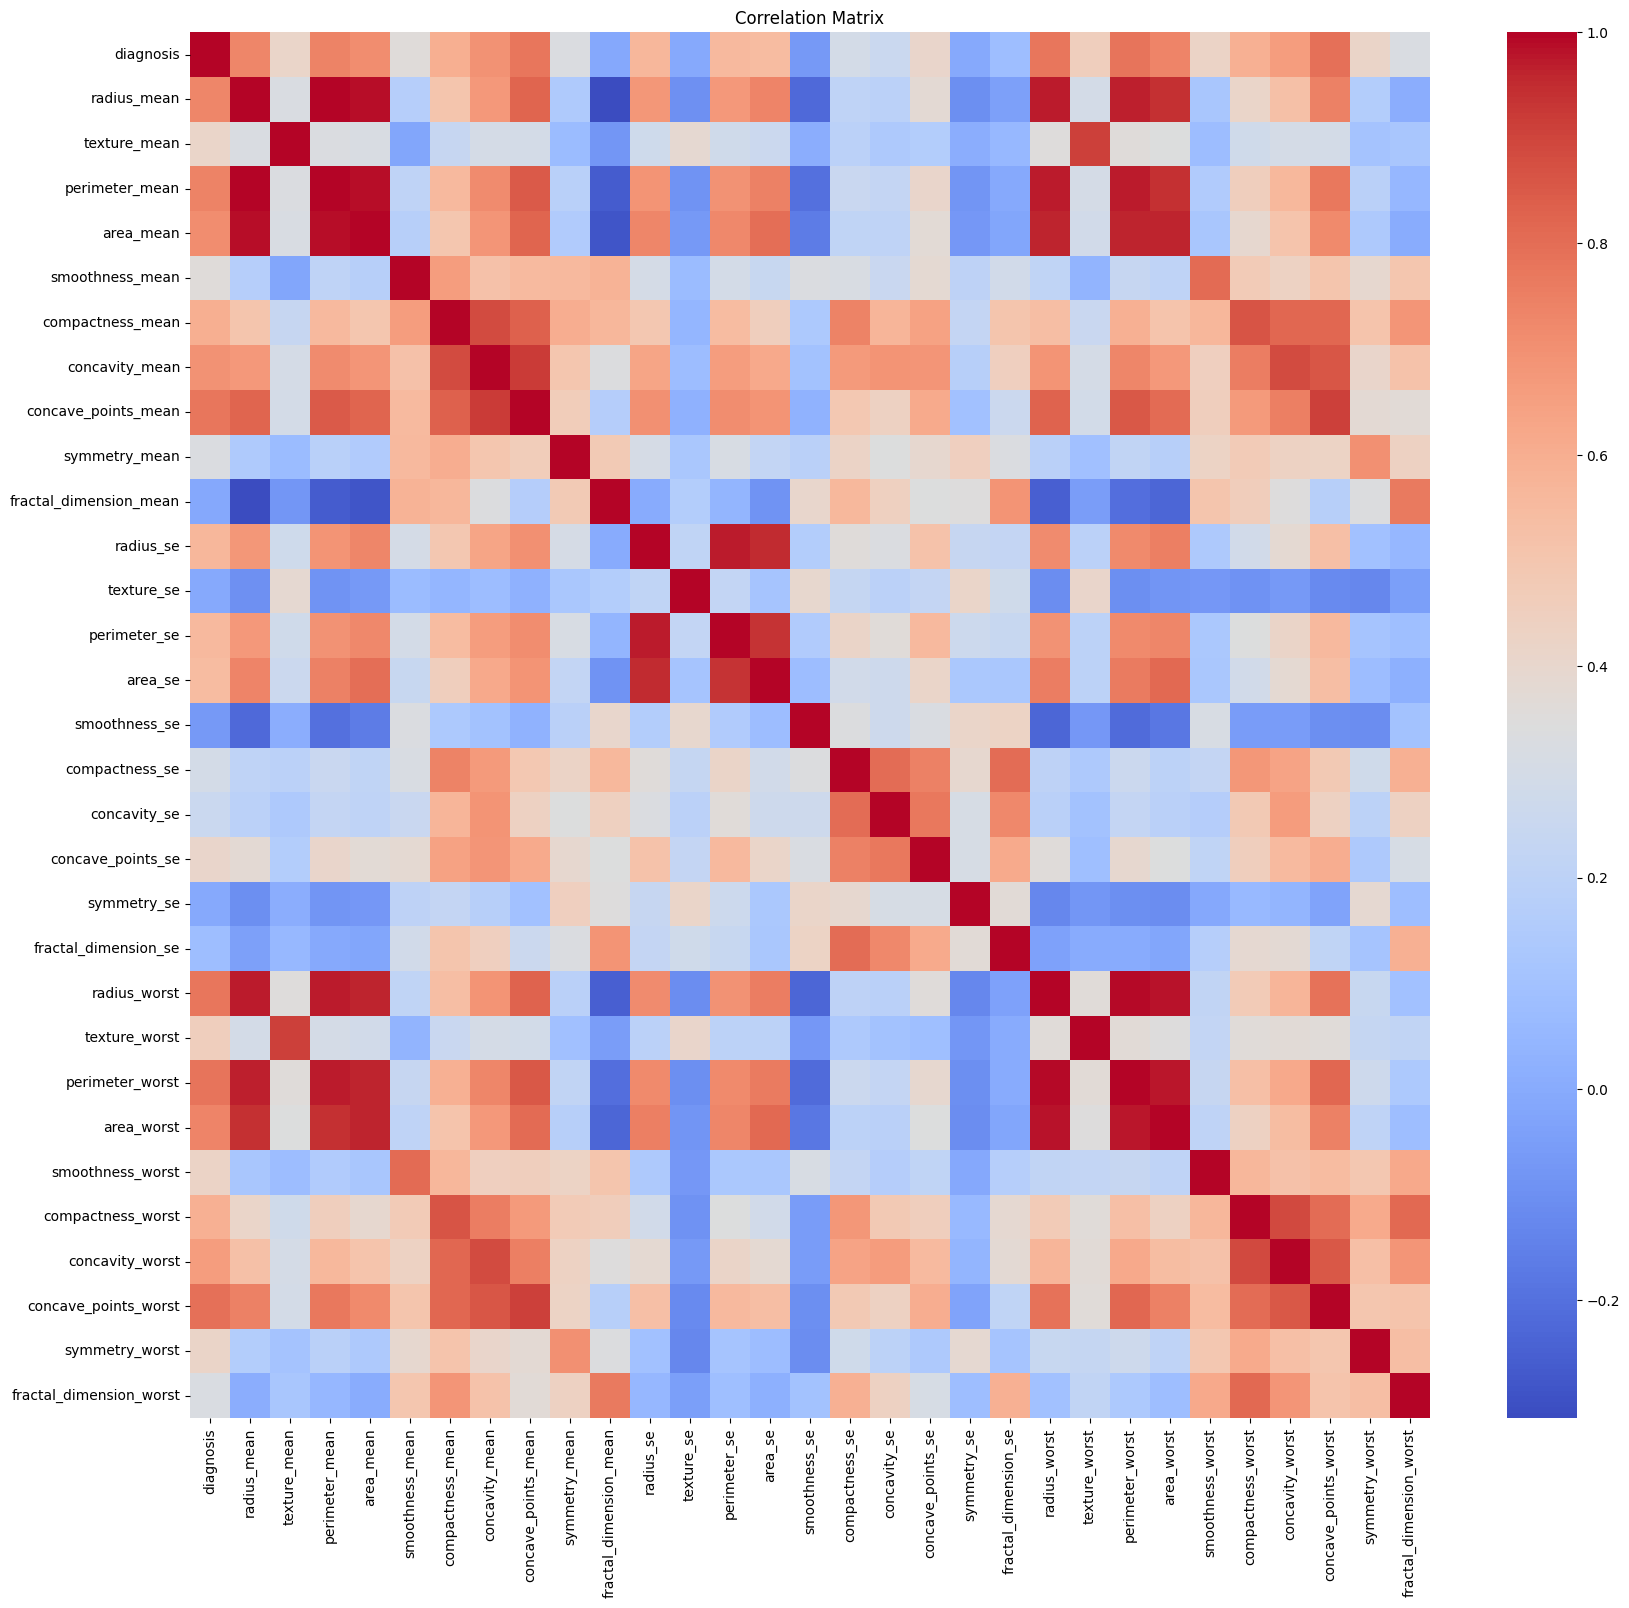

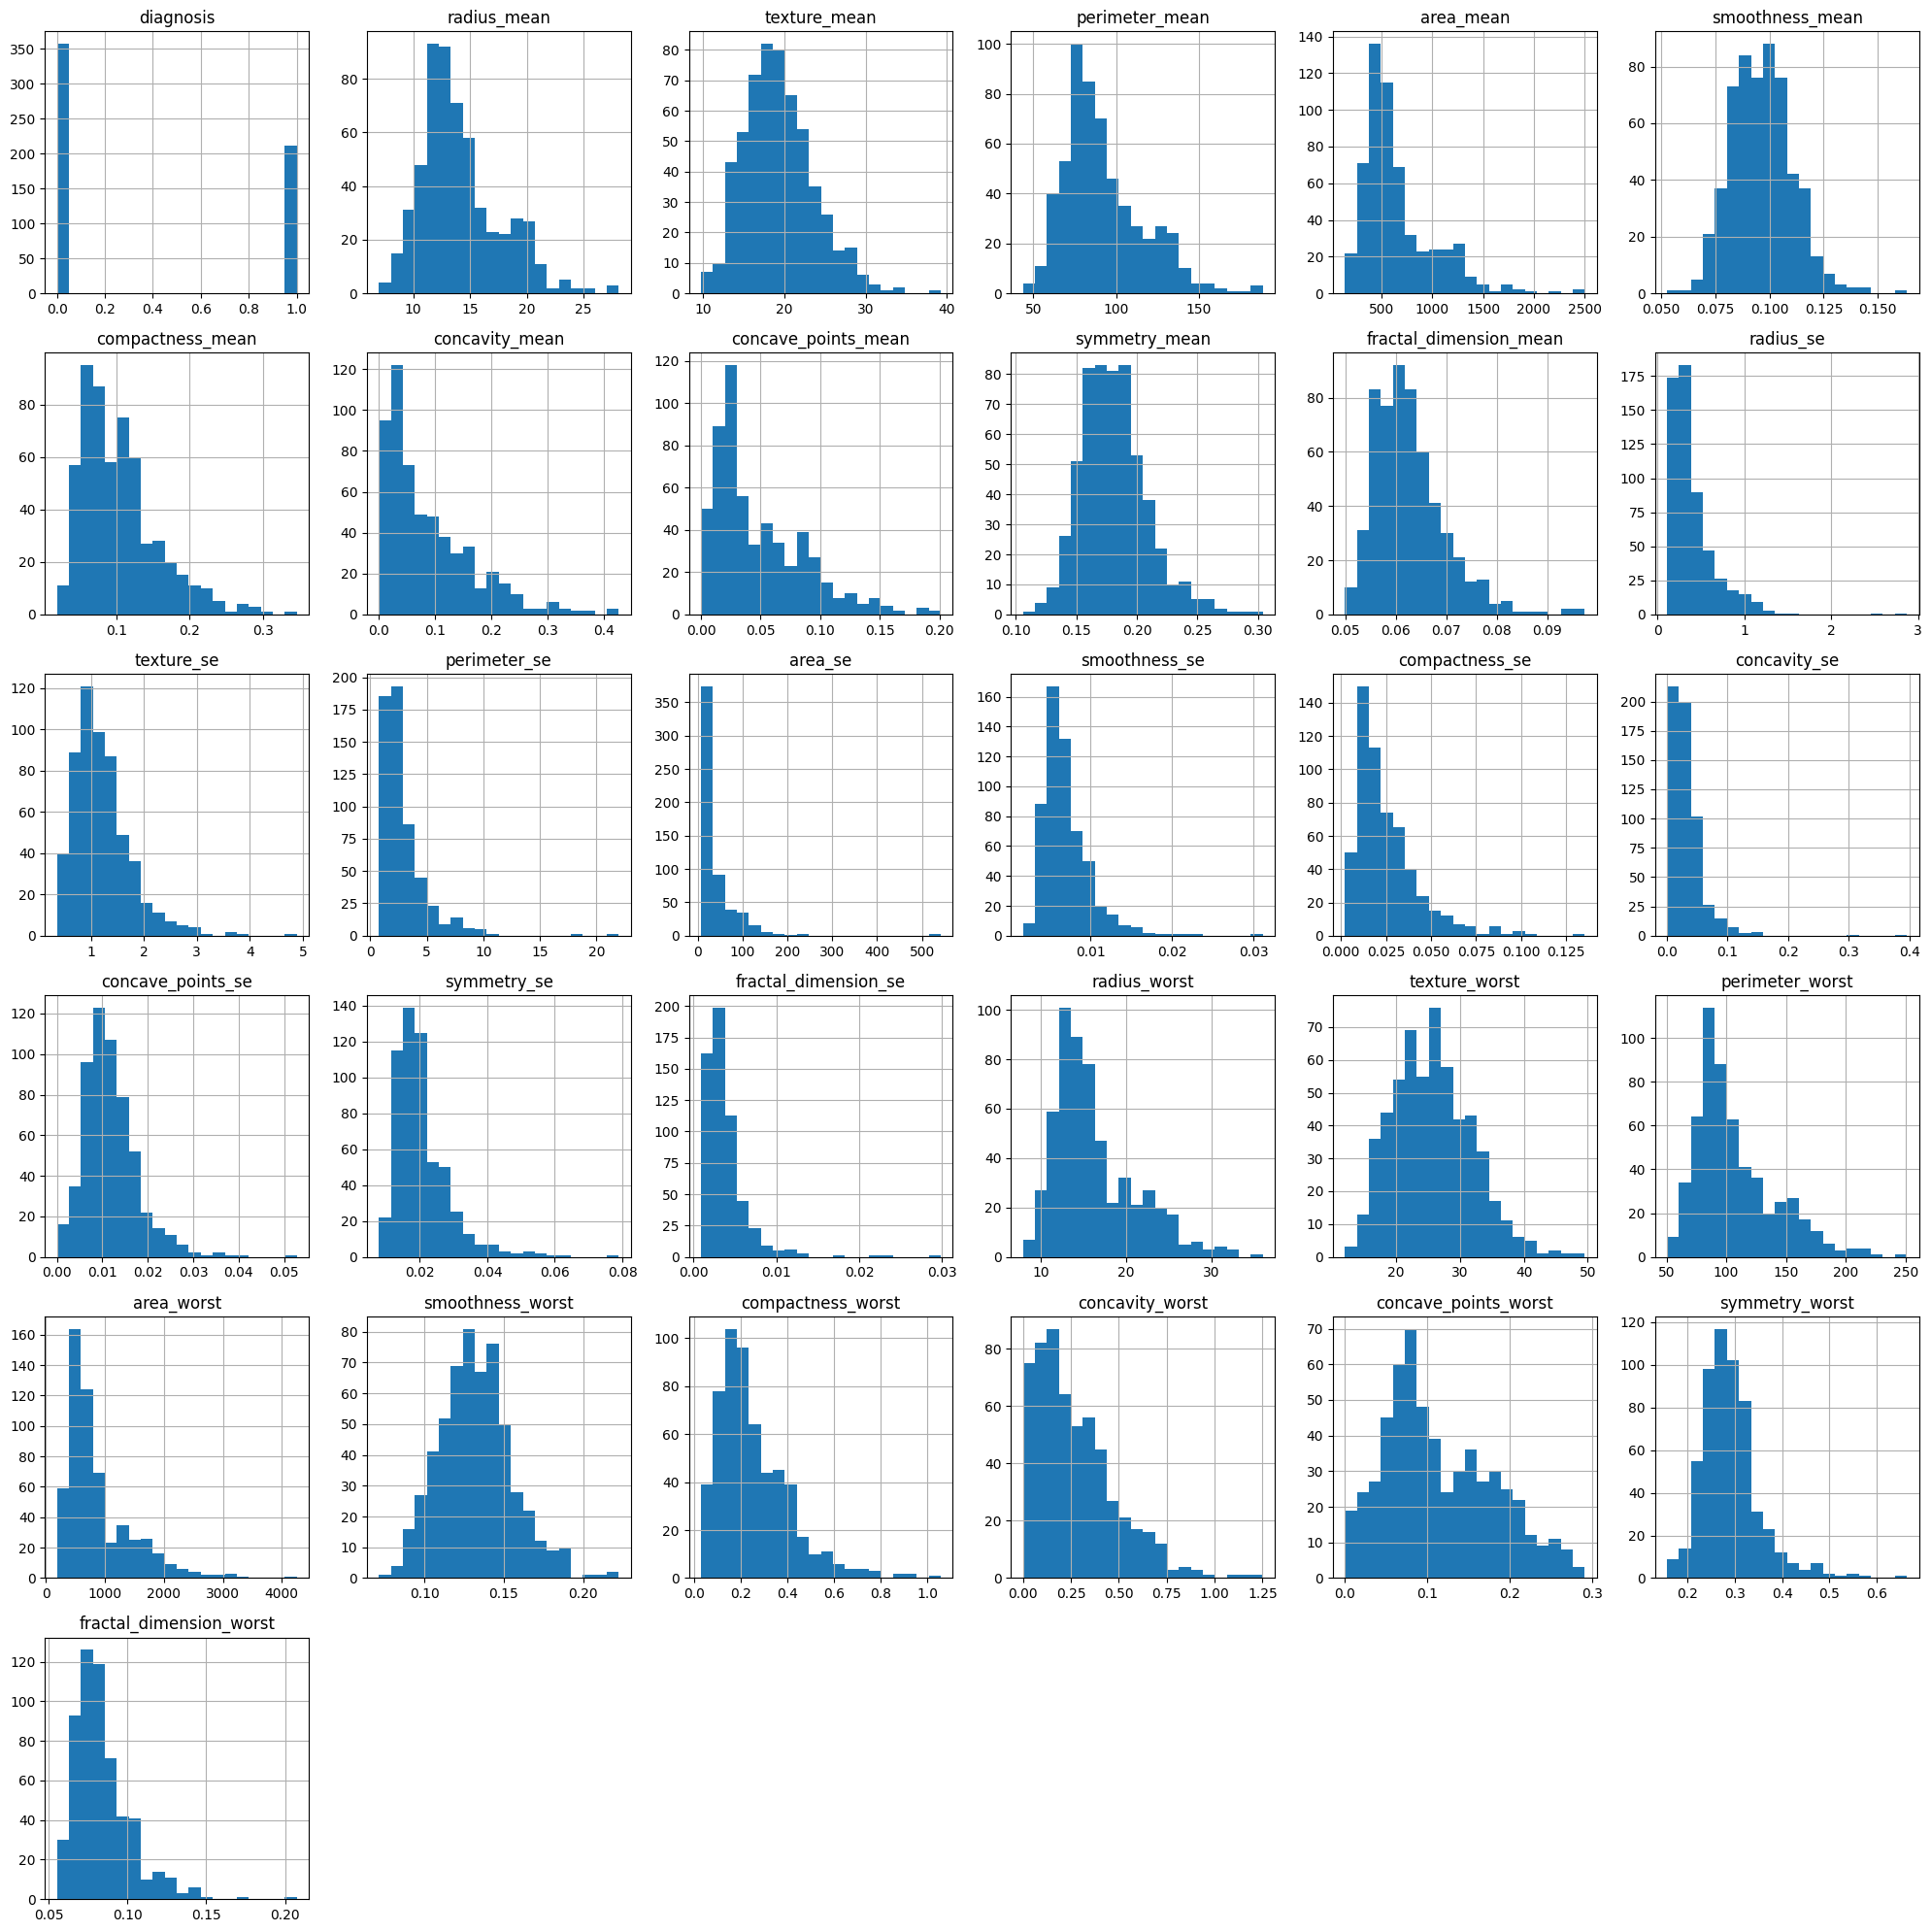

In [3]:
# EDA
plt.figure(figsize=(20, 18))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

df.hist(figsize=(20, 20), bins=20)
plt.tight_layout()
plt.show()

In [4]:
# SVM Analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# A. Kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
print("--- SVM Kernels (Default) ---")
for kernel in kernels:
    clf = SVC(kernel=kernel, random_state=42)
    clf.fit(X_train_scaled, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test_scaled))
    print(f"Kernel: {kernel}, Accuracy: {acc:.4f}")

# B. Tuning RBF
print("\n--- Tuning RBF ---")
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}
grid = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)
print(f"Best Params: {grid.best_params_}")
print(f"Tuned Accuracy: {accuracy_score(y_test, grid.predict(X_test_scaled)):.4f}")

--- SVM Kernels (Default) ---
Kernel: linear, Accuracy: 0.9649
Kernel: poly, Accuracy: 0.8830
Kernel: rbf, Accuracy: 0.9591
Kernel: sigmoid, Accuracy: 0.9591

--- Tuning RBF ---
Best Params: {'C': 1, 'gamma': 0.01}
Tuned Accuracy: 0.9532
